In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from typing import Dict, Tuple, List, Union, Any
from pathlib import Path
from jsonlines import jsonlines
from loguru import logger
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from IPython.display import display_markdown

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from src.settings import EMBEDDINGS_DIR, TASK_LABEL_NAME_MAP, TASK_ID2NAME

tqdm.pandas()

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')
print(f"{DEVICE=}")

torch.cuda.empty_cache()

DEVICE=device(type='cuda', index=0)


## Dataset

In [3]:
augmented_pl_df = pd.read_feather(EMBEDDINGS_DIR / 'augmented_pl_annots_wth_emb_df.feather')  #.sample(frac=0.5)
augmented_pl_df

,start,end,text,doc_filepath,video_filename,task_label,ParaphraseSrcIndex,EmbeddingModel,Embedding
0,39040,41120,"Myślę, że mam inny pomysł, można?",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.039401535, 0.045144096, -0.07359799, 0.999..."
1,41120,49680,"Chyba ten znak mówi, że jak ktoś będzie spacer...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.04103174, 0.18905145, -0.2473697, 0.999101..."
2,49680,55280,Trzeba przejść łukiem obok leżącego i o tym zn...,/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.099419735, 0.2554967, -0.2758171, 0.996696..."
3,61280,66840,"Okrągły znak pomaga nam, mówi, że są pasy na u...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.23825723, -0.018337265, -0.06085317, 0.998..."
4,66840,73200,"Jak ktoś zobaczy, ale zignoruje ten znak, to m...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.12970479, 0.22667503, -0.34039426, 0.99525..."
...,...,...,...,...,...,...,...,...,...
47543,229040,230040,Obrazki już się skończyły.,/08/K03AF01-21_08_frog_08_frog_frog.eaf,K03AF01-21.mp4,08,30706.0,allegro/herbert-base-cased,"[-0.078688405, 0.10844632, 0.042495422, 0.9991..."
47544,423040,424640,Prąd.,/15/K04BF15-26_15_15_signsNO.eaf,K04BF15-26.mp4,15,341.0,allegro/herbert-base-cased,"[-0.027012182, 0.24136762, -0.04894121, 0.9986..."
47545,23480,26760,"On właśnie mówi im, że jest zmęczony i chce iś...",/24/K67AF13-26_24_24_alarm.eaf,K67AF13-26.mp4,24,11942.0,allegro/herbert-base-cased,"[0.015946332, -0.046507165, -0.20022015, 0.998..."
47546,493560,494680,Specjalne owijki na nogi.,/15/K42BF01-15_15_15_signsNO.eaf,K42BF01-15.mp4,15,6698.0,allegro/herbert-base-cased,"[-0.25153598, 0.05548507, -0.071281515, 0.9990..."


In [4]:
augmented_pl_df["TaskName"] = augmented_pl_df["task_label"].apply(lambda x: TASK_LABEL_NAME_MAP[x])
augmented_pl_df

,start,end,text,doc_filepath,video_filename,task_label,ParaphraseSrcIndex,EmbeddingModel,Embedding,TaskName
0,39040,41120,"Myślę, że mam inny pomysł, można?",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.039401535, 0.045144096, -0.07359799, 0.999...",Znaki zakazu
1,41120,49680,"Chyba ten znak mówi, że jak ktoś będzie spacer...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.04103174, 0.18905145, -0.2473697, 0.999101...",Znaki zakazu
2,49680,55280,Trzeba przejść łukiem obok leżącego i o tym zn...,/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.099419735, 0.2554967, -0.2758171, 0.996696...",Znaki zakazu
3,61280,66840,"Okrągły znak pomaga nam, mówi, że są pasy na u...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.23825723, -0.018337265, -0.06085317, 0.998...",Znaki zakazu
4,66840,73200,"Jak ktoś zobaczy, ale zignoruje ten znak, to m...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.12970479, 0.22667503, -0.34039426, 0.99525...",Znaki zakazu
...,...,...,...,...,...,...,...,...,...,...
47543,229040,230040,Obrazki już się skończyły.,/08/K03AF01-21_08_frog_08_frog_frog.eaf,K03AF01-21.mp4,08,30706.0,allegro/herbert-base-cased,"[-0.078688405, 0.10844632, 0.042495422, 0.9991...",Sylwester / Żaba
47544,423040,424640,Prąd.,/15/K04BF15-26_15_15_signsNO.eaf,K04BF15-26.mp4,15,341.0,allegro/herbert-base-cased,"[-0.027012182, 0.24136762, -0.04894121, 0.9986...",Znaki zakazu
47545,23480,26760,"On właśnie mówi im, że jest zmęczony i chce iś...",/24/K67AF13-26_24_24_alarm.eaf,K67AF13-26.mp4,24,11942.0,allegro/herbert-base-cased,"[0.015946332, -0.046507165, -0.20022015, 0.998...",Alarm
47546,493560,494680,Specjalne owijki na nogi.,/15/K42BF01-15_15_15_signsNO.eaf,K42BF01-15.mp4,15,6698.0,allegro/herbert-base-cased,"[-0.25153598, 0.05548507, -0.071281515, 0.9990...",Znaki zakazu


In [5]:
label2id = {v: k for k, v in TASK_ID2NAME.items()}
label2id

{'Kalendarz': 0,
 'Sylwester / Żaba': 1,
 'Komisky': 2,
 'Znaki zakazu': 3,
 'Gruszki / Chaplin': 4,
 'Alarm': 5}

In [45]:
PARAHRASE_PREVIEW_SAMPLE_SIZE = 10

md_str = "| Task | Text | Paraphrase |\n|:-|:-|:-|"
for _, row in augmented_pl_df[augmented_pl_df.ParaphraseSrcIndex.notna()].sample(PARAHRASE_PREVIEW_SAMPLE_SIZE).sort_values("TaskName").iterrows():
    src_index = int(row.ParaphraseSrcIndex)
    paraphrase = row["text"]
    src_text = augmented_pl_df.loc[src_index]["text"]
    
    if src_text == paraphrase:
        continue

    task_str = row.TaskName

    md_str += f"\n| {task_str} | {src_text} | {paraphrase} |"

display_markdown(md_str, raw=True)

| Task | Text | Paraphrase |
|:-|:-|:-|
| Gruszki / Chaplin | Odwraca się i pyta: co?. | Odwraca się i zadaje pytanie: co? |
| Gruszki / Chaplin | Pierwsza - już, druga - już, biegnie do trzeciej. | Pierwsza już, druga już, biegnie do trzeciej. |
| Kalendarz | Proponuję, na przykład ósma? | Czy mogę zaproponować, na przykład ósmą? |
| Kalendarz | Pasowało. | Było to odpowiednie. |
| Kalendarz | Mam urlop nad morzem. | Jestem na urlopie nad morzem. |
| Sylwester / Żaba | Ten chłopiec szuka, razem z psem szukają jej w parku. | Ten chłopiec wraz z psem poszukują jej w parku. |
| Sylwester / Żaba | A ptak też groził palcem. | Ptak również groził palcem. |
| Znaki zakazu | Na egzaminie na prawo jazdy takiego znaku nie ma. | Na egzaminie na prawo jazdy nie ma takiego znaku. |
| Znaki zakazu | Albo czyjś krew jest w wannie i to informuje, że nie wolno się tu kąpać. | Jeśli ktoś ma krew w wannie, to oznacza, że nie można się tu kąpać. |
| Znaki zakazu | Żółty znak w kształcie trójkąta informuje, że można się poślizgnąć, widzę, że jest jeszcze strzałka w dół. | Wygląda na to, że żółty znak w kształcie trójkąta informuje, że można się poślizgnąć. Zauważam, że jest jeszcze strzałka w dół. |

In [7]:
# remove paraphrases that are duplicates of the original text
augmented_pl_df = augmented_pl_df.drop_duplicates(subset=["text"], keep="first")

In [8]:
augmented_pl_df.ParaphraseSrcIndex.notna().sum()

4891

In [9]:
f"{augmented_pl_df.ParaphraseSrcIndex.notna().sum() / len(augmented_pl_df) * 100:.2f}%"

'13.27%'

In [10]:
def get_target_vec(label, label2id):
    target_vec = np.zeros(len(label2id))
    target_vec[label2id[label]] = 1
    return target_vec

augmented_pl_df["Target"] = augmented_pl_df["TaskName"].apply(get_target_vec, args=(label2id,))

/tmp/ipykernel_34145/1230884072.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  augmented_pl_df["Target"] = augmented_pl_df["TaskName"].apply(get_target_vec, args=(label2id,))


In [11]:
class OrkpjmTaskDataset(Dataset):

    def __init__(self, augmented_df, augment=False):
        self.df = augmented_df.copy()
        if not augment:
            self.df = self.df[self.df.ParaphraseSrcIndex.isna()]

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        return {
            "embedding": torch.tensor(self.df.Embedding.iloc[index]),
            "target": torch.tensor(self.df.Target.iloc[index]),
        }

In [12]:
aug_train_df, aug_val_df = train_test_split(augmented_pl_df, test_size=0.2, random_state=42, stratify=augmented_pl_df["task_label"])

len(aug_train_df), len(aug_val_df)

(29491, 7373)

In [13]:
train_ds = OrkpjmTaskDataset(aug_train_df)
val_ds = OrkpjmTaskDataset(aug_val_df)

In [14]:
aug_train_ds = OrkpjmTaskDataset(aug_train_df, augment=True)
aug_val_ds = OrkpjmTaskDataset(aug_val_df, augment=True)

## Data loaders

In [15]:
EMBEDDINGS_DIM = 768
BATCH_SIZE = 64
NUM_LABELS = 6


train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

aug_train_dl = DataLoader(aug_train_ds, batch_size=BATCH_SIZE)
aug_val_dl = DataLoader(aug_train_ds, batch_size=BATCH_SIZE)

## Simple NN

In [16]:
class SimpleNNclf(nn.Module):

    def __init__(self, embedding_dim, num_classes, hidden_dim=256, dropout=0.5):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = nn.functional.relu(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return nn.functional.softmax(x, dim=1)

In [17]:
SimpleNNclf(EMBEDDINGS_DIM, NUM_LABELS)

SimpleNNclf(
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
)

## LSTM

In [18]:
class LSTMclf(nn.Module):

    def __init__(self, input_dim, num_classes, hidden_dim=256):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, bidirectional=False, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1])
        # x shape: [batch_size, sequence_length, embedding_dim]
        lstm_out, _ = self.lstm(x)
        # Take the output of the last time step
        lstm_out = lstm_out[:, -1, :]
        out = self.dropout(lstm_out)
        out = self.fc(out)
        return nn.functional.softmax(out, dim=1)

In [19]:
LSTMclf(EMBEDDINGS_DIM, NUM_LABELS)

LSTMclf(
  (lstm): LSTM(768, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)

In [20]:
def train(model, optimizer, loss_fn, train_dl, device="cuda", norm_grad=False):
    # one epoch training
    model.train()
    total_loss = 0

    all_targets_label_ids, all_preds_label_ids = [], []
    for batch in train_dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        inputs, targets = batch["embedding"], batch["target"]

        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_fn(preds, targets)
        total_loss = total_loss + loss.item()
        loss.backward()

        if norm_grad:
            # Normalizacja wartości gradientów
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        preds_label_ids = torch.argmax(preds, dim=1)
        targets_label_ids = torch.argmax(targets, dim=1)

        all_preds_label_ids.extend(preds_label_ids.detach().cpu().numpy())
        all_targets_label_ids.extend(targets_label_ids.detach().cpu().numpy())

    avg_loss = total_loss / len(train_dl)

    # print(all_targets_label_ids[:10], all_preds_label_ids[:10])
    
    clf_report = classification_report(all_targets_label_ids, all_preds_label_ids, output_dict=True, zero_division=0)

    return avg_loss, clf_report


def evaluate(model, loss_fn, val_dl, device="cuda"):
    # one epoch evaluation
    model.eval()
    total_loss = 0
    all_targets_label_ids, all_preds_label_ids = [], []
    for batch in val_dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        inputs, targets = batch["embedding"], batch["target"]

        with torch.no_grad():
            preds = model(inputs)
            loss = loss_fn(preds, targets)
            total_loss = total_loss + loss.item()

        targets_label_ids = torch.argmax(targets, dim=1)
        preds_label_ids = torch.argmax(preds, dim=1)

        all_preds_label_ids.extend(preds_label_ids.detach().cpu().numpy())
        all_targets_label_ids.extend(targets_label_ids.detach().cpu().numpy())

    avg_loss = total_loss / len(val_dl)
    clf_report = classification_report(all_targets_label_ids, all_preds_label_ids, output_dict=True, zero_division=0)
    
    all_preds_label_names = [TASK_ID2NAME[x] for x in all_preds_label_ids]
    all_targets_label_names = [TASK_ID2NAME[x] for x in all_targets_label_ids]

    cm = confusion_matrix(all_targets_label_names, all_preds_label_names, labels=list(TASK_ID2NAME.values()))

    return avg_loss, clf_report, cm

In [21]:
EPOCHS = 50
LEARNING_RATE = 1e-3


training_history = []
for (exp_train_dl, exp_val_dl), augmented in tqdm([
    ((train_dl, val_dl), False),
    ((aug_train_dl, aug_val_dl), True),
], desc="Datasets", position=0):

    for model_base_class in tqdm([
        LSTMclf,
        SimpleNNclf
    ], desc="Models", position=1, leave=False):
        torch.cuda.empty_cache()

        model = model_base_class(EMBEDDINGS_DIM, NUM_LABELS).to(DEVICE)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        model_name = model.__class__.__name__
        for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs", position=2, leave=False):
            train_loss, train_clf_report = train(model, optimizer, loss_fn, train_dl, norm_grad=False, device=DEVICE)
            val_loss, val_clf_report, val_cm = evaluate(model, loss_fn, val_dl, device=DEVICE)

            train_f1 = train_clf_report["macro avg"]["f1-score"]
            val_f1 = val_clf_report["macro avg"]["f1-score"]

            # logger.info(f"Augmented: {augmented}\tTrain loss: {train_loss:.4f} Val loss: {val_loss:.4f} Train F1: {train_f1:.4f} Val F1: {val_f1:.4f}")

            training_history.append({
                "Epoch": epoch,
                "Model": model_name,
                "AugmentedDataset": augmented,
                "TrainLoss": train_loss,
                "ValLoss": val_loss,
                "TrainF1": train_f1,
                "ValF1": val_f1,
                "ValPrecision": val_clf_report["macro avg"]["precision"],
                "ValRecall": val_clf_report["macro avg"]["recall"],
                "_ValClfReport": val_clf_report,
                "_ValCM": val_cm
            })

Datasets:   0%|          | 0/2 [00:00<?, ?it/s]

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

In [22]:
training_history_df = pd.DataFrame.from_records(training_history)
training_history_df.to_json("nlp_final_final_final_training_history_df.jsonl", orient="records", lines=True)
training_history_df

,Epoch,Model,AugmentedDataset,TrainLoss,ValLoss,TrainF1,ValF1,ValPrecision,ValRecall,_ValClfReport,_ValCM
0,1,LSTMclf,False,1.562559,1.477634,0.313024,0.398965,0.368746,0.441191,"{'0': {'precision': 0.7417721518987341, 'recal...","[[879, 28, 0, 268, 43, 0], [35, 449, 0, 135, 3..."
1,2,LSTMclf,False,1.466098,1.476213,0.405108,0.397627,0.428655,0.454404,"{'0': {'precision': 0.5218009478672986, 'recal...","[[1101, 4, 1, 94, 18, 0], [109, 395, 1, 97, 39..."
2,3,LSTMclf,False,1.448715,1.430875,0.434607,0.449885,0.679885,0.479514,"{'0': {'precision': 0.7157164869029276, 'recal...","[[929, 1, 4, 266, 18, 0], [51, 414, 13, 168, 3..."
3,4,LSTMclf,False,1.432187,1.434788,0.470702,0.447356,0.605922,0.485251,"{'0': {'precision': 0.6291925465838509, 'recal...","[[1013, 5, 1, 178, 21, 0], [74, 427, 7, 109, 3..."
4,5,LSTMclf,False,1.419847,1.423348,0.493307,0.488838,0.585971,0.508662,"{'0': {'precision': 0.6351606805293005, 'recal...","[[1008, 6, 3, 187, 13, 1], [73, 578, 21, 109, ..."
...,...,...,...,...,...,...,...,...,...,...,...
195,46,SimpleNNclf,True,1.377241,1.405011,0.596905,0.568655,0.607780,0.577051,"{'0': {'precision': 0.7534807534807535, 'recal...","[[920, 9, 7, 254, 8, 20], [39, 612, 48, 139, 9..."
196,47,SimpleNNclf,True,1.374885,1.393820,0.603298,0.574778,0.628078,0.571304,"{'0': {'precision': 0.6916083916083916, 'recal...","[[989, 8, 8, 187, 23, 3], [61, 530, 50, 109, 2..."
197,48,SimpleNNclf,True,1.377133,1.396873,0.602964,0.571543,0.618344,0.566629,"{'0': {'precision': 0.7206325301204819, 'recal...","[[957, 12, 10, 220, 17, 2], [54, 590, 51, 122,..."
198,49,SimpleNNclf,True,1.370923,1.400064,0.607250,0.566804,0.632298,0.563870,"{'0': {'precision': 0.7706342311033884, 'recal...","[[887, 10, 4, 295, 15, 7], [40, 578, 36, 159, ..."


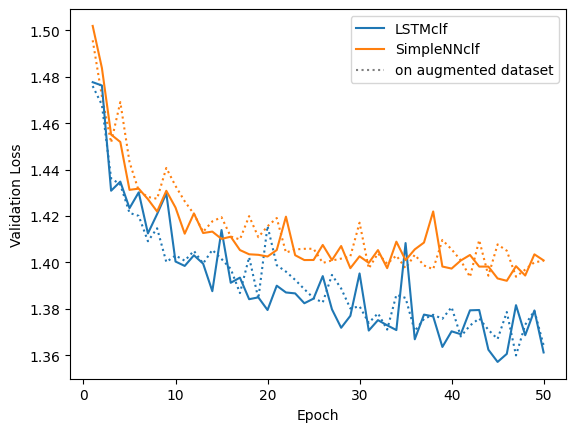

In [23]:
fig_val_loss= plt.figure()

sns.lineplot(data=training_history_df[training_history_df.AugmentedDataset], x="Epoch", y="ValLoss", hue="Model", linestyle=":", legend=False)
sns.lineplot(data=training_history_df[~training_history_df.AugmentedDataset], x="Epoch", y="ValLoss", hue="Model")

handles, _ = plt.gca().get_legend_handles_labels()
line = Line2D([0], [0], label='on augmented dataset', color='gray', linestyle=':')
handles.append(line)
plt.legend(handles=handles)

plt.ylabel("Validation Loss")
plt.xlabel("Epoch")
plt.show()

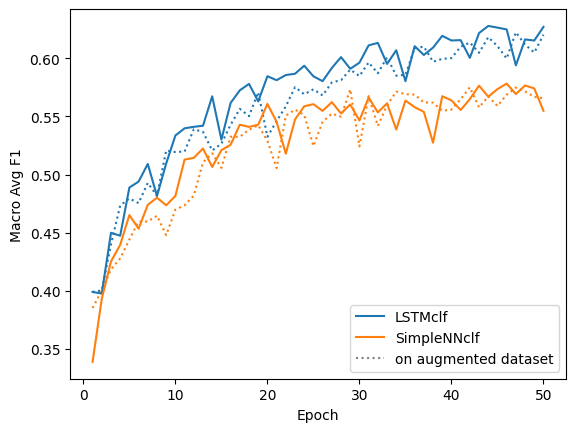

In [32]:
fig_f1= plt.figure()

sns.lineplot(data=training_history_df[training_history_df.AugmentedDataset], x="Epoch", y="ValF1", hue="Model", linestyle=":", legend=False)
sns.lineplot(data=training_history_df[~training_history_df.AugmentedDataset], x="Epoch", y="ValF1", hue="Model")

handles, _ = plt.gca().get_legend_handles_labels()
line = Line2D([0], [0], label='on augmented dataset', color='gray', linestyle=':')
handles.append(line)
plt.legend(handles=handles)

plt.ylabel("Macro Avg F1")
plt.xlabel("Epoch")
plt.show()

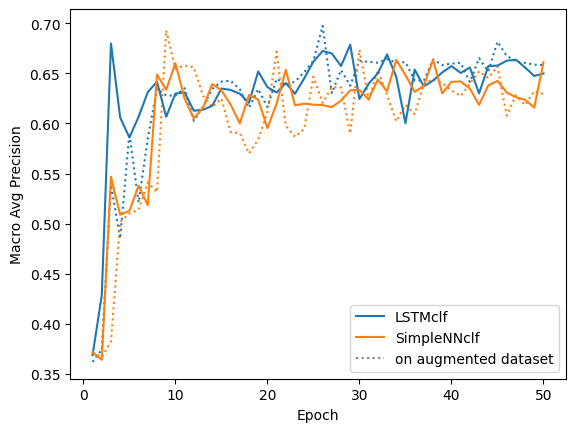

In [33]:
fig_precision= plt.figure()

sns.lineplot(data=training_history_df[training_history_df.AugmentedDataset], x="Epoch", y="ValPrecision", hue="Model", linestyle=":", legend=False)
sns.lineplot(data=training_history_df[~training_history_df.AugmentedDataset], x="Epoch", y="ValPrecision", hue="Model")

handles, _ = plt.gca().get_legend_handles_labels()
line = Line2D([0], [0], label='on augmented dataset', color='gray', linestyle=':')
handles.append(line)
plt.legend(handles=handles)

plt.ylabel("Macro Avg Precision")
plt.xlabel("Epoch")
plt.show()

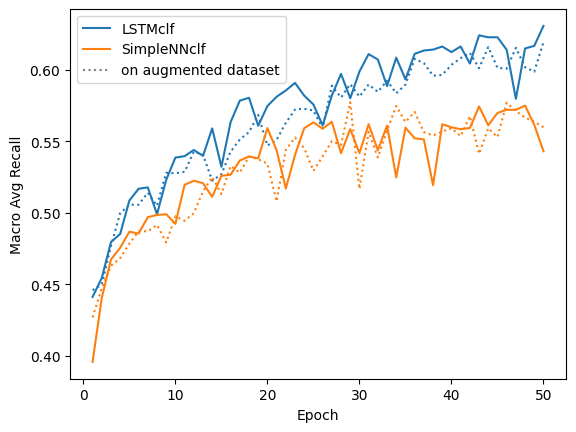

In [35]:
fig_recall = plt.figure()

sns.lineplot(data=training_history_df[training_history_df.AugmentedDataset], x="Epoch", y="ValRecall", hue="Model", linestyle=":", legend=False)
sns.lineplot(data=training_history_df[~training_history_df.AugmentedDataset], x="Epoch", y="ValRecall", hue="Model")

handles, _ = plt.gca().get_legend_handles_labels()
line = Line2D([0], [0], label='on augmented dataset', color='gray', linestyle=':')
handles.append(line)
plt.legend(handles=handles)

plt.ylabel("Macro Avg Recall")
plt.xlabel("Epoch")
plt.show()

In [36]:
max_f1_df = training_history_df.groupby(['Model', 'AugmentedDataset'])['ValF1'].max().reset_index().sort_values(by="ValF1", ascending=False)
max_f1_df

,Model,AugmentedDataset,ValF1
0,LSTMclf,False,0.627858
1,LSTMclf,True,0.622356
2,SimpleNNclf,False,0.578256
3,SimpleNNclf,True,0.575063


In [37]:
def add_bar_labels(ax):
    """
    Add labels on top of each bar in seaborn barplot.
    """
    y_anchor = 1.02
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + (p.get_height() * y_anchor)
        value = '{:.3f}'.format(p.get_height())
        if value == '{:.3f}'.format(0):
            continue
        ax.text(_x, _y, value, ha="center", va='bottom', fontsize=9)

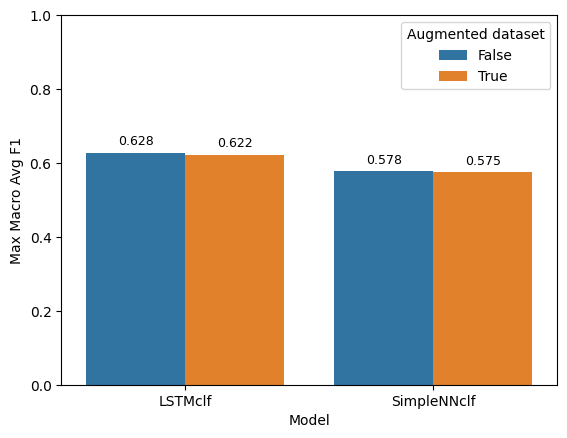

In [39]:
fig_dataset_best_f1 = plt.figure()

sns.barplot(data=max_f1_df, x="Model", y="ValF1", hue="AugmentedDataset")
add_bar_labels(plt.gca())
plt.legend(loc='upper right', title="Augmented dataset")
plt.ylim(0, 1)
plt.ylabel("Max Macro Avg F1")
plt.show()

In [40]:
best_f1_indices_df = training_history_df.groupby(['Model', 'AugmentedDataset'])['ValF1'].idxmax().reset_index()
best_f1_indices_df

,Model,AugmentedDataset,ValF1
0,LSTMclf,False,43
1,LSTMclf,True,146
2,SimpleNNclf,False,95
3,SimpleNNclf,True,191


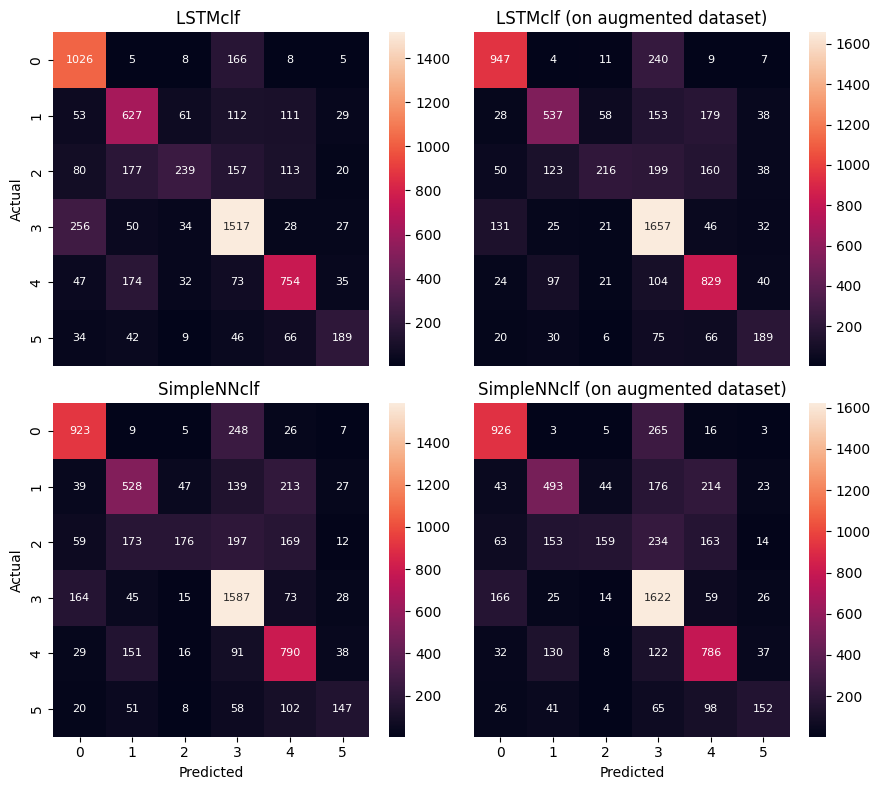

In [41]:
fig_cms, axes = plt.subplots(2, 2, figsize=(9, 8))
for (i, ax), (_, row) in zip(enumerate(axes.flatten()), best_f1_indices_df.iterrows()):
    best_f1_idx = row.ValF1
    cm = training_history_df.loc[best_f1_idx]._ValCM

    sns.heatmap(cm, annot=True, annot_kws={"size": 8}, fmt="g", ax=ax)
    if i % 2 == 0:
        ax.set_ylabel('Actual')
    if i >= 2:
        ax.set_xlabel('Predicted')
    if i in [0, 1]:
        ax.set_xticks([])
    if i in [1, 3]:
        ax.set_yticks([])

    ax.set_title(f"{row.Model} {'(on augmented dataset)' if row.AugmentedDataset else ''}")

plt.tight_layout()
plt.show()